In [37]:
import matplotlib.pyplot as plt
import numpy as np
import equations
import math

%matplotlib inline

In [38]:
# Calibrations index vectors for combustion duration
# Combustion duration vectors (1x20)
combDurationVecE100 = [14.315, 14.888, 15.514, 15.929, 17.006, 16.812, 16.52, 18.693, 18.096, 17.447, 18.361, 18.349, 18.17, 17.988, 18.186, 17.908, 18.168, 18.861, 19.76, 20.953]
combDurationVecE22 = [16.016, 16.366, 16.356, 16.838, 17.656, 17.445, 17.633, 18.533, 18.371, 17.848, 19.066, 19.096, 19.256, 19.023, 19.261, 19.658, 20.383, 21.321, 21.291, 22.778]
# Engine speed input vector
engSpeedVec = [1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250]

In [39]:
# Structural engine parameters
# Connecting rod (m)
connRodLength = 183.2e-3
# Crankshaft radius (m)
crankRadius = 43.15e-3
# Piston diameter (m)
pistonDiameter = 70e-3
# Cylinder volume (m³)
cylClearanceVol = 32.64e-6
# Clearance volume height (m)
cylclearanceHeight = cylClearanceVol / (math.pi * pistonDiameter/2) ** 2
# Piston area (m²)
pistonArea = math.pi * (pistonDiameter/2) ** 2
# Crank radius to connecting rod length ratio (m)
crankConnRodRatio = crankRadius / connRodLength
# Max piston displacement (m)
maxPistonDisp = 2 * crankRadius
# Total cylinder displaced volume (m³)
cylinderDispVol = cylClearanceVol + maxPistonDisp*pistonArea
# Clearance volume related area at top dead center (m²)
clearanceVolArea = cylClearanceVol / cylclearanceHeight

In [40]:
# Engine operating conditions
# Engine speed (RPM)
engSpeed = 2000
# Spark advance (CA)
sparkAdvance = 10
# Fuel mass injected per cyclinder per cycle (kg/cyc)
fuelMass = 40.03e-6
# AF ratio
airFuelRatio = 7.8
# Intake manifold pressure (Pa)
intManifoldPress = 90700
# Intake manifold Temperature (K)
intManifoldTemp = 292

In [41]:
# Air, fuel and heat transfer process properties
# Fuel lower heating value (J/kg) - E100 = 24.65e6; E22 = 38.92e6
lowerFuelHeatVal = 24.65e6
# Max fuel heat release per cylinder per cycle (J/cyc)
maxFuelHeatRelease = lowerFuelHeatVal * fuelMass
# Specific gas constant considering dry air (j/kg.K)
gasConst = 287
# Stoichiometric AF ratio (J/Kg) - E100 = 8.5; E22 = 13.2
stoichiAirFuelRatio = 13.2
# Stoichiometric air mass (kg)
stoichiAirMass = stoichiAirFuelRatio * fuelMass
# Actual air mass (kg)
airMass = airFuelRatio * fuelMass
# Air excess factor
airExcessFactor = airMass / stoichiAirMass

In [42]:
# Heat release properties
# Wiebe factor
wiebeFactor = 2.6
# Burned percentage considered at start of combustion
burnedFuelStart = 0.1
burnedFuelStartConst = -math.log(1 - burnedFuelStart)
# Burned percentage at end of combustion
burnedFuelEnd = 0.9
burnedFuelEndConst = -math.log(1 - burnedFuelEnd)

In [43]:
# Simulation parameters
# Crankshaft angle calculation step
crankStep = 0.5
# Number of cycles to simulate
totalCycles = 1
cycleCounter = 0
# Crank angle at intake valve closing (CA)
crankAngleIvc = 180
# Crank angle at exhaust valve opening (CA)
crankAngleEvo = 540

In [44]:
# Data vectors
# Cylinder pressure

cylinderPressData = []

In [45]:
# Cycles simulation
for cycle in range(totalCycles):
    # Parameters initialization before beginning of cycle
    # Cylinder temperature at intake valve closing (K)
    cylTempIvc = intManifoldTemp
    # Cylinder pressure at intake valve closing (Pa)
    cylPressIvc = intManifoldPress
    # Cylinder pressure at start of high pressure cycle (Pa)
    cylinderPress = cylPressIvc
    # Combustion duration
    combDuration = equations.get_mapped_value(engSpeedVec, combDurationVecE22, 1, engSpeed)
    # Average piston speed (m/s)
    avgPistonSpeed = 4 * crankRadius * engSpeed / 60
    # Average cylinder wall temperature (K)
    avgCylWallTemp = 360 + 9 * (airExcessFactor ** 0.4) * math.sqrt(engSpeed * pistonDiameter)
    # Wiebe's form factor
    formFactorWiebe = (combDuration / (burnedFuelEndConst ** (1 / (wiebeFactor + 1)) - burnedFuelStartConst ** (1 / (wiebeFactor + 1)))) ** (-wiebeFactor - 1)
    # Unburned mixture temperature (K)
    mixtureTemp = intManifoldPress * cylinderDispVol * intManifoldTemp / (cylinderDispVol * intManifoldPress)

    # Initial conditions for high pressure cycle
    # Cylinder volume one crank step before intake valve closure (m³)
    cylinderVolPrev =  cylClearanceVol + equations.piston_disp(crankAngleIvc, crankRadius, crankConnRodRatio) * pistonArea
    # Combustion related variables
    fuelMassUnburnedPrev = fuelMass
    fuelHeatRelease = 0
    fuelHeatReleasePrev = 0
    fuelMassBurnedDelta = 0

    # Compression and expanion strokes
    for crankAngle in np.arange(crankAngleIvc + crankStep, crankAngleEvo + crankStep, crankStep):
        # Piston displacement relative to top dead center (m)
        pistonDisp = equations.piston_disp(crankAngle, crankRadius, crankConnRodRatio)
        # Cylinder volume (m³)
        cylinderVol = cylClearanceVol + pistonArea * pistonDisp
        # Cylinder volume delta in between consecutive crank steps (m³)
        cylinderVolDelta = cylinderVol - cylinderVolPrev
        # Specific heat constant (J/kg.K)
        specHeatConst = 700 + 0.255 * mixtureTemp
        # Polytropic exponent
        polytropicExp = 1 + gasConst / specHeatConst
        # Unburned mixture temperature (K)
        mixtureTemp = cylinderPress * cylinderVol * intManifoldTemp / (cylinderDispVol * intManifoldPress)
        # Convective heat transfer coefficient (W/m².K)
        heatTransfCoeff = equations.heat_transfer_coeff(cylinderVol, cylinderPress, mixtureTemp, avgPistonSpeed)
        # Combustion chamber area (m)
        combChamberArea = 2 * math.pi * (pistonDisp + cylclearanceHeight)

        # Combustion process
        if 360 - sparkAdvance <= crankAngle:
            fuelBurnRate = (1 - math.exp(-formFactorWiebe * (crankAngle - (360 - sparkAdvance)) ** (wiebeFactor + 1)))
            # Fuel heat release
            fuelHeatRelease = maxFuelHeatRelease * fuelBurnRate
            # Remaining fuel mass
            fuelMassUnburned = fuelMass * (1 - fuelBurnRate)
            # Fuel mass burned delta
            fuelMassBurnedDelta = fuelMassUnburned - fuelMassUnburnedPrev
            # Fuel mass unburned
            fuelMassUnburnedPrev = fuelMassUnburned
            
        # Fuel heat release rate (J/CA) 
        fuelHeatReleaseRateDelta = fuelHeatRelease - fuelHeatReleasePrev
        # Rate of heat transferred to cylinder walls (J/kg)
        heatTransfCylWallRate = 1 / (360 * engSpeed / 60) * heatTransfCoeff * combChamberArea * (mixtureTemp - avgCylWallTemp)
        # Cylinder pressure rate of change (Pa)
        cylinderPressDelta = equations.cylinder_press(gasConst, specHeatConst, cylinderVol, fuelHeatReleaseRateDelta, heatTransfCylWallRate, fuelMassBurnedDelta, cylinderPress, cylinderVolDelta)
        # Actual cylinder pressure
        cylinderPress = cylinderPress + cylinderPressDelta

        # State variables update for next cycle
        # Cylinder volume
        cylinderVolPrev = cylinderVol
        # Fuel heat released
        fuelHeatReleasePrev = fuelHeatRelease

        # Data vectors update
        # In-cylinder pressure (Pa)
        cylinderPressData.append(cylinderPress)

        

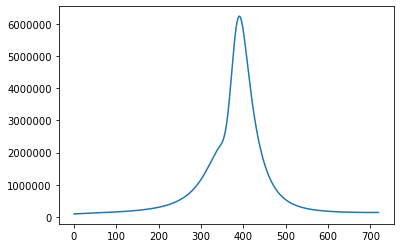

In [46]:
plt.plot(cylinderPressData)